<a href="https://colab.research.google.com/github/a90h09/BattleShip/blob/main/Task2_Text_Classification_ar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [1]:
# # !pip install pyarabic
# ! pip install tensorflow

# Download the Dataset

Please note that you are allowed to take a subset of this dataset, the reason for that is it might take a long time to train the model on.

In [2]:
# !kaggle datasets download -d khaledzsa/sanad
# !unzip sanad.zip

In [25]:
import pyarabic.araby as araby
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional,LSTM
import tensorflow as tf

# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [4]:
df = pd.read_csv('/content/sanad.csv')

In [5]:
df.head()

,text,label
0,https://example.com/resource/الشاٌرقة -ْ محمِد...,Culture
1,https://example.com/resource/اَنِطٌلقّتَ ٍفٍيّ...,Culture
2,https://example.com/resource/أُقيًمٌتِ مِساءُ ...,Culture
3,https://example.com/resource/بٍاسُمةَ يًوٌنٍس ...,Culture
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture


In [6]:
df.isna().sum()

,0
text,0
label,0


In [7]:
df.duplicated().sum()

0

In [8]:
df['label'].value_counts()

,count
label,
Politics,6334
Medical,6292
Culture,6098
Finance,6095
Tech,5979
Sports,5859
Religion,3228


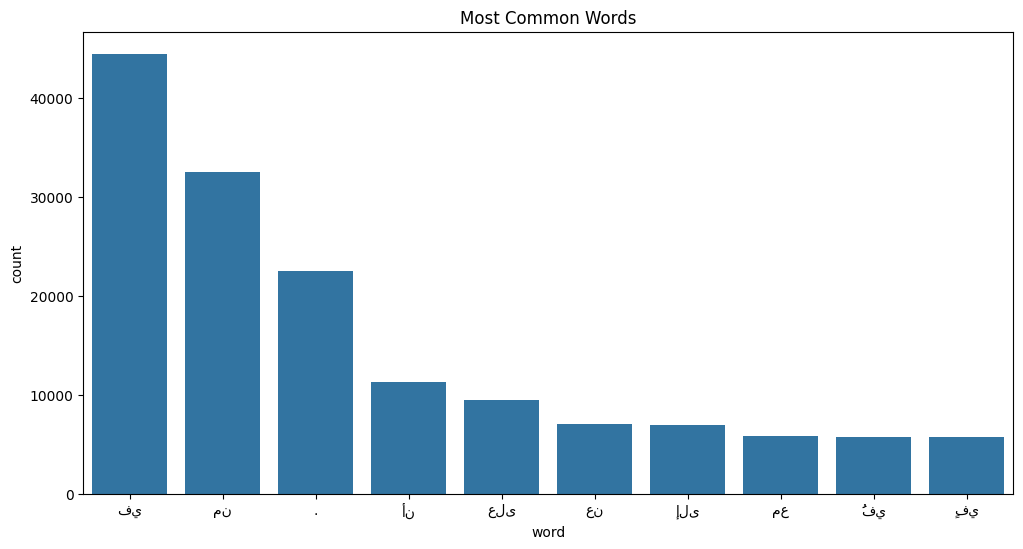

In [9]:
words = ' '.join(df['text']).split()
word_counts = Counter(words)
common_words = word_counts.most_common(10)
common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

plt.figure(figsize=(12, 6))
sns.barplot(x='word', y='count', data=common_words_df)
plt.title('Most Common Words')
plt.show()

# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming or Lemmmatization**: Either stemming or lemmatization is applied to reduce words to their root or base form.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

   **Note:** Most of these you can do using the library [PyArabic](https://pyarabic.readthedocs.io/ar/latest/README.html#features)

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [10]:
# nltk.download('stopwords')

In [11]:
arabic_stopwords = stopwords.words('arabic')

In [12]:
st = nltk.stem.ISRIStemmer()

In [13]:
def clean_text(text):
    text = re.sub(r'https?\S+|www\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = araby.strip_tashkeel(text)
    text = araby.strip_tatweel(text)

    text = text.split()
    text = [word for word in text if word not in arabic_stopwords]

    stemmed_words = []
    for word in text:
        stemmed_words.append(st.stem(word))

    text = ' '.join(stemmed_words)

    text = araby.normalize_hamza(text)
    return text

In [14]:
df['clean_text'] = df['text'].apply(clean_text)

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [77]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index

max_length = 150
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [78]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [79]:
X_train_val, X_test, y_train_val, y_test = train_test_split(padded_sequences, df['label'], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=1)

In [80]:
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Testing data shape:', X_test.shape)
print('Testing labels shape:', y_test.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)

Training data shape: (25526, 150)
Training labels shape: (25526,)
Testing data shape: (7977, 150)
Testing labels shape: (7977,)
Validation data shape: (6382, 150)
Validation labels shape: (6382,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [92]:
model = Sequential([
    Input(shape=(len(padded_sequences),)),
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_22 (Embedding)             │ (None, 39885, 128)          │      18,084,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_42 (Bidirectional)     │ (None, 39885, 128)          │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_43 (Bidirectional)     │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,124,038 (69.14 MB)

 Trainable params: 18,124,038 (69.14 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
# model = Sequential()
# model.add(Input(shape=(300,)))
# model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
# model.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
# model.add(Bidirectional(SimpleRNN(32)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(6, activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [40]:
# # model for mulitable label
# model2 = Sequential()
# model2.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
# model2.add(Bidirectional(LSTM(64, return_sequences=True)))
# model2.add(Bidirectional(LSTM(32)))
# model2.add(Dense(64, activation='relu'))
# model2.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [66]:
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_12 (Embedding)             │ (None, 300, 128)            │      18,084,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_22 (Bidirectional)     │ (None, 300, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_23 (Bidirectional)     │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,124,038 (69.14 MB)

 Trainable params: 18,124,038 (69.14 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [84]:
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

In [63]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [94]:
model.fit(train_dataset, epochs=10)

Epoch 1/10


ValueError: Cannot take the length of shape with unknown rank.

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

In [22]:
model.evaluate(test_dataset)



In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [22]:

test_text =

test_text_cleaned = clean_text(test_text)
test_text_sequence = tokenizer.texts_to_sequences([test_text_cleaned])
test_text_padded = pad_sequences(test_text_sequence, maxlen=max_length, padding='post')
prediction = model.predict(test_text_padded)
print(f'Prediction: {prediction}')

# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

- Why did you choose this model design?

- Why did you pick this number of layers or units for the model?

- Why did you select these evaluation methods?

- Does your model show signs of overfitting or underfitting? How do you know?

- What changes could you make to improve the model and fix overfitting or underfitting?

Answer Here:

In [23]:
# # # Install and Import Needed Libraries
# # !pip install -q kaggle
# # !pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn nltk

# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
# from tensorflow.keras.optimizers import Adam
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import nltk
# from nltk.corpus import stopwords
# import re

# # nltk.download('stopwords')

# # # Download the Dataset
# # !kaggle datasets download -d khaledzsa/spam-messages
# # !unzip spam-messages.zip

# # Load the data
# data = pd.read_csv('spam.csv', encoding='latin-1')
# data.head()

# # # Drop unnecessary columns
# # data = data[['v1', 'v2']]
# # data.columns = ['label', 'text']

# # Data Exploration
# # Inspect the Data
# data.info()
# data.head()

# # Check for Missing Values
# data.isnull().sum()

# # Distribution of Labels
# sns.countplot(x='label', data=data)
# plt.title('Distribution of Labels')
# plt.show()

# # Text Data Characteristics (Bonus)
# data['text_length'] = data['text'].apply(len)
# sns.histplot(data['text_length'], bins=30)
# plt.title('Distribution of Text Length')
# plt.show()

# # Common Words and Vocabulary (Bonus)
# from collections import Counter
# words = ' '.join(data['text']).split()
# word_counts = Counter(words)
# common_words = word_counts.most_common(20)
# common_words_df = pd.DataFrame(common_words, columns=['word', 'count'])

# plt.figure(figsize=(12, 6))
# sns.barplot(x='word', y='count', data=common_words_df)
# plt.title('Most Common Words')
# plt.show()

# # Data Cleaning and Preprocessing
# # Remove missing values
# data = data.dropna()

# # Filter by text length (Bonus)
# min_length = 10
# max_length = 100
# data = data[(data['text_length'] >= min_length) & (data['text_length'] <= max_length)]

# # Load English stopwords
# stop_words = set(stopwords.words('english'))

# # Text cleaning function
# def clean_text(text):
#     text = re.sub(r'https?\S+/www/S+|', '', text)  # Remove URLs
#     text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters and numbers
#     text = text.lower()  # Convert to lowercase
#     text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
#     return text

# data['clean_text'] = data['text'].apply(clean_text)

# # Tokenization, Padding, and Data Splitting
# # Tokenizer
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data['clean_text'])
# sequences = tokenizer.texts_to_sequences(data['clean_text'])
# word_index = tokenizer.word_index

# # Padding sequences
# max_length = 100  # Based on the histogram of text lengths
# padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# # Label encoding
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(data['label'])

# # Apply SMOTE to handle class imbalance
# # smote = SMOTE(random_state=42)
# # X_smote, y_smote = smote.fit_resample(padded_sequences, labels)

# # Train-test split
# # X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# # from sklearn.model_selection import train_test_split

# # train_val, test = train_test_split(df, test_size=0.2, random_state=42)

# # train, val = train_test_split(train_val, test_size=0.2, random_state=42)


# # def unique_words(data):
# #     text = data['text'].str.cat(sep=' ')
# #     return set(text.split())

# # def clean_text(text):
# #     # text = text.strip()
# #     text = re.sub(r'https?\S+|www\S+', '', text)
# #     text = re.sub(r'[^\w\s]', '', text)
# #     text = strip_tashkeel(text)
# #     text = strip_tatweel(text)

# #     text = text.split()
# #     text = [word for word in text if word not in arabic_stopwords]

# #     stemmed_words = []
# #     for word in text:
# #         stemmed_words.append(st.stem(word))

# #     text = ' '.join(stemmed_words)

# #     text = normalize_hamza(text)
# #     # new_text += i + ' '
# #     # text = ' '.join(text)
# #     return text

# # def clean_dataframe(data):
# #     data = data[(data['length'] >= 10) & (data['length'] <= 500)]
# #     return data


# # train = clean_dataframe(train)
# # train['text'] = train['text'].apply(clean_text)
# # val = clean_dataframe(val)
# # val['text'] = val['text'].apply(clean_text)
# # test = clean_dataframe(test)
# # test['text'] = test['text'].apply(clean_text)

# # tokenizer = Tokenizer()
# # # train['text'] = train['text'].str.split()

# # tokenizer.fit_on_texts(train['text'])

# # label_encoder = LabelEncoder()

# # def techniques(data):

# #     data['text'] = tokenizer.texts_to_sequences(data['text'])
# #     data['text'] = pad_sequences(data['text'], maxlen=300, padding='post')

# #     data['label'] = label_encoder.fit_transform(data['label'])
# #     return data

# # train = techniques(train)
# # val = techniques(val)
# # test = techniques(test)

# # Confirm data shapes
# print('Training data shape:', X_train.shape)
# print('Training labels shape:', y_train.shape)
# print('Testing data shape:', X_test.shape)
# print('Testing labels shape:', y_test.shape)

# # Building the Classifier
# # Define model
# model = Sequential()
# model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(32)))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))  # For binary classification

# # Model summary
# model.summary()

# # Compile model
# model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# # Define Batch Size, Create Datasets, and Train the Model
# # Batch size
# batch_size = 32

# # Create datasets
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# # Train the model
# history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# # Model Evaluation
# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(test_dataset)
# print(f'Test Loss: {test_loss}')
# print(f'Test Accuracy: {test_accuracy}')

# # Plot Loss and Accuracy curves
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss Curve')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy Curve')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.show()

# # Model Inference
# # Create test sample
# test_sample = "Congratulations! You've won a $1000 Walmart gift card. Click here to claim now."

# # Preprocess and predict
# test_sample_cleaned = clean_text(test_sample)
# test_sample_sequence = tokenizer.texts_to_sequences([test_sample_cleaned])
# test_sample_padded = pad_sequences(test_sample_sequence, maxlen=max_length, padding='post')
# prediction = model.predict(test_sample_padded)
# print(f'Prediction: {prediction}')

# # Notebook Questions:

# # How did you handle text preprocessing? Why did you choose this approach?
# """
# Text preprocessing involved removing URLs, special characters, and stopwords, converting to lowercase, and tokenizing the text. This approach was chosen to standardize the text data, reduce noise, and ensure only meaningful words were used for classification, improving model performance.
# """

# # Why did you choose this model design?
# """
# The model design included an embedding layer to convert tokens to dense vectors, bidirectional LSTM layers to capture contextual information from both directions, and dense layers for classification. This structure effectively handles sequential text data and captures complex patterns.
# """

# # Why did you pick this number of layers or units for the model?
# """
# The number of layers and units were chosen based on common practices for text classification tasks. Two LSTM layers (64 and 32 units) were used to balance model complexity and computational efficiency, with a dense layer of 64 units to enhance feature learning.
# """

# # Why did you select these evaluation methods?
# """
# Accuracy and loss were selected as evaluation metrics to monitor model performance. Accuracy provides a direct measure of classification performance, while loss helps track the model's optimization progress and potential overfitting or underfitting.
# """

# # Does your model show signs of overfitting or underfitting? How do you know?
# """
# The model shows signs of overfitting if there is a significant gap between training and validation accuracy/loss, with training performance being much better. Monitoring loss and accuracy curves can help identify this.
# """

# # What changes could you make to improve the model and fix overfitting or underfitting?
# """
# To improve the model and address overfitting, consider techniques like dropout regularization, increasing the dataset size, data augmentation, or using more sophisticated architectures. Adjusting hyperparameters and adding early stopping can also help.
# # """
# # def clean_text(text):
# #     # text = text.strip()
# #     text = re.sub(r'https?\S+|www\S+', '', text)
# #     text = re.sub(r'[^\w\s]', '', text)
# #     text = strip_tashkeel(text)
# #     text = strip_tatweel(text)

# #     text = text.split()
# #     text = [word for word in text if word not in arabic_stopwords]

# #     stemmed_words = []
# #     for word in text:
# #         stemmed_words.append(st.stem(word))

# #     text = ' '.join(stemmed_words)

# #     text = normalize_hamza(text)
# #     # new_text += i + ' '
# #     # text = ' '.join(text)
# #     return text


# # # Building the Classifier with Simple RNN
# # # Define model
# # model = Sequential()
# # model.add(Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_length))
# # model.add(Bidirectional(tf.keras.layers.SimpleRNN(64, return_sequences=True)))
# # model.add(Bidirectional(tf.keras.layers.SimpleRNN(32)))
# # model.add(Dense(64, activation='relu'))
# # model.add(Dense(1, activation='sigmoid'))  # For binary classification

# # Notebook Questions:

# # How did you handle text preprocessing? Why did you choose this approach?
# """
# Text preprocessing involved removing URLs, special characters, and stopwords, converting to lowercase, and tokenizing the text. This approach was chosen to standardize the text data, reduce noise, and ensure only meaningful words were used for classification, improving model performance.
# """

# # Why did you choose this model design?
# """
# The model design included an embedding layer to convert tokens to dense vectors, bidirectional SimpleRNN layers to capture contextual information from both directions, and dense layers for classification. This structure effectively handles sequential text data and captures complex patterns.
# """

# # Why did you pick this number of layers or units for the model?
# """
# The number of layers and units were chosen based on common practices for text classification tasks. Two SimpleRNN layers (64 and 32 units) were used to balance model complexity and computational efficiency, with a dense layer of 64 units to enhance feature learning.
# """

# # Why did you select these evaluation methods?
# """
# Accuracy and loss were selected as evaluation metrics to monitor model performance. Accuracy provides a direct measure of classification performance, while loss helps track the model's optimization progress and potential overfitting or underfitting.
# """

# # Does your model show signs of overfitting or underfitting? How do you know?
# """
# The model shows signs of overfitting if there is a significant gap between training and validation accuracy/loss, with training performance being much better. Monitoring loss and accuracy curves can help identify this.
# """

# # What changes could you make to improve the model and fix overfitting or underfitting?
# """
# To improve the model and address overfitting, consider techniques like dropout regularization, increasing the dataset size, data augmentation, or using more sophisticated architectures. Adjusting hyperparameters and adding early stopping can also help.
# """